In [1]:
import os, sys, glob, pickle
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

/home/lucas/miniconda3/envs/sips/lib/python3.7/site-packages/geopandas/_compat.py:78: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
root='/home/lucas/repos/solar-pv-global-inventory'

In [3]:
match_files = glob.glob(os.path.join(root,'data','match_wri_*_4000_0.05*.gpkg'))

In [4]:
match_files += glob.glob(os.path.join(root,'data','match_eia*.gpkg'))

In [5]:
match_files = [f for f in match_files if 'wri_US' not in f]

In [6]:
match_files

['/home/lucas/repos/solar-pv-global-inventory/data/match_wri_GT_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_JP_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_ES_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_FR_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_AU_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_MX_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_GR_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_NA_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_MR_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_ZA_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_IN_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv-global-inventory/data/match_wri_SA_4000_0.05.gpkg',
 '/home/lucas/repos/solar-pv

In [7]:
match_df = gpd.GeoDataFrame(pd.concat([gpd.read_file(f) for f in match_files]))

In [8]:
#gdf = gpd.read_file(os.path.join(root,'data','ABCD_lccapacity.geojson'))
gdf = gpd.read_file(os.path.join(root,'data','ABCD_landcover.geojson')) # for EIA matching

In [9]:
gdf = gdf.reset_index().rename(columns={'index':'unique_id'})

### rm AF false positives

In [10]:
import json
from shapely import geometry

In [11]:
#json.dump(ll, open(os.path.join(root,'data','AF_drop.json'),'w'))
ll = json.load(open(os.path.join(root,'data','AF_drop.json'),'r'))

In [12]:
records = [{'pt':geometry.Point(el)} for el in ll]

In [13]:
df = pd.DataFrame.from_records(records)

In [14]:
drop_pts = gpd.GeoDataFrame(df, geometry='pt',crs={'init':'epsg:4326'})

/home/lucas/miniconda3/envs/sips/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
gdf.columns

Index(['unique_id', 'area', 'confidence', 'install_date', 'install_date_ints',
       'SPOT_ids_0', 'S2_ids_0', 'iso-3166-1', 'iso-3166-2',
       'land_cover_CORINE_2006', 'land_cover_CORINE_2012',
       'land_cover_CORINE_2018', 'land_cover_MODIS_2006',
       'land_cover_MODIS_2007', 'land_cover_MODIS_2008',
       'land_cover_MODIS_2009', 'land_cover_MODIS_2010',
       'land_cover_MODIS_2011', 'land_cover_MODIS_2012',
       'land_cover_MODIS_2013', 'land_cover_MODIS_2014',
       'land_cover_MODIS_2015', 'land_cover_MODIS_2016',
       'land_cover_MODIS_2017', 'land_cover_MODIS_2018', 'SPOT_ids_1',
       'SPOT_ids_2', 'S2_ids_1', 'SPOT_ids_3', 'SPOT_ids_4', 'SPOT_ids_5',
       'SPOT_ids_6', 'SPOT_ids_7', 'SPOT_ids_8', 'land_cover_CDL_2006',
       'land_cover_CDL_2007', 'land_cover_CDL_2008', 'land_cover_CDL_2009',
       'land_cover_CDL_2010', 'land_cover_CDL_2011', 'land_cover_CDL_2012',
       'land_cover_CDL_2013', 'land_cover_CDL_2014', 'land_cover_CDL_2015',
       'land

In [16]:
gdf = gdf[~gdf.geometry.intersects(drop_pts.unary_union)]

In [17]:
gdf = gdf[gdf.capacity_mw>0.01]

AttributeError: 'GeoDataFrame' object has no attribute 'capacity_mw'

### Merge in matches

In [18]:
EU_28 = ['AT','BE','BG','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE','GB']

In [19]:
gdf = gdf.merge(match_df[['unique_id','match_id']], how='left',left_on='unique_id',right_on='unique_id')

In [20]:
gdf.loc[(gdf['iso-3166-1']=='US')&(gdf['match_id']!=''),['install_date','match_id','geometry']]

,install_date,match_id,geometry
23980,<2016-06,EIA58553,"POLYGON ((-86.26061 39.65490, -86.26057 39.654..."
23983,2017-07-09,EIA60640,"POLYGON ((-69.67412 44.55592, -69.67412 44.556..."
23984,2017-01-19,EIA60764,"POLYGON ((-104.44252 39.79316, -104.44250 39.7..."
23985,<2016-06,EIA60046,"POLYGON ((-87.15650 41.55875, -87.15638 41.558..."
23989,<2016-06,EIA58639,"POLYGON ((-159.31060 22.12990, -159.31054 22.1..."
...,...,...,...
68708,<2016-06,EIA59390,"POLYGON ((-70.88931 42.84639, -70.88944 42.846..."
68710,2016-11-14,EIA59636,"POLYGON ((-72.02031 42.13495, -72.02065 42.134..."
68711,<2016-06,EIA60609,"POLYGON ((-72.10437 41.57628, -72.10439 41.576..."
68730,2016-12-23,EIA59511,"POLYGON ((-81.66370 35.17854, -81.66354 35.178..."


#### ... to file

In [ ]:
gdf.to_file(os.path.join(root,'data','ABCD_finalized.geojson'),driver='GeoJSON')

In [ ]:
gdf['capacity_mw']

### Compare to wri & eia

In [21]:
wri_df = pd.read_csv(os.path.join(root, 'data','WRI_gppd.csv'))

In [22]:
eia_df = gpd.read_file(os.path.join(root,'data','eia_powerstations','PowerPlants_US_202001.shp'))

In [23]:
eia_meta = pd.read_csv(os.path.join(root,'data','eia_powerstations','february_generator2020.csv'))

In [24]:
iso2 = pd.read_csv(os.path.join(root,'data','iso2.csv'))

In [25]:
wri_df = wri_df.merge(iso2[['iso3','iso2']], how='left',left_on='country',right_on='iso3')

#### How much in each country?

In [ ]:
for iso2 in sorted(gdf['iso-3166-1'].unique()):
    N = (gdf['iso-3166-1']==iso2).sum()
    N_wri = (wri_df['iso2']==iso2).sum()
    matched_to = ((gdf['iso-3166-1']==iso2) & (gdf['match_id']!='')).sum() / (gdf['iso-3166-1']==iso2).sum()
    matched_from = len(gdf.loc[gdf['iso-3166-1']==iso2,'match_id'].unique()) / N_wri
    print (iso2, N, N_wri,matched_to,matched_from )

In [ ]:
gdf.loc[gdf['match_id']=='','capacity_mw'].sum() / gdf['capacity_mw'].sum()

In [26]:
gdf['install_date'] = gdf['install_date'].str.replace('<2016-06','2001-01-01')
gdf['install_date'] = gdf['install_date'].str.replace(',','')
gdf['install_date'] = gdf['install_date'].str[0:10]

In [27]:
print ('install_date')
print (gdf['install_date'].unique())
gdf['dt_obj'] = pd.to_datetime(gdf['install_date'])

install_date
['' '2001-01-01' '2017-04-24' '2016-12-29' '2016-09-08' '2017-11-03'
 '2016-08-28' '2016-06-02' '2017-09-02' '2018-01-19' '2018-02-22'
 '2017-05-26' '2018-09-22' '2018-07-10' '2016-08-24' '2016-09-03'
 '2017-03-29' '2018-05-27' '2016-07-03' '2016-09-21' '2016-12-27'
 '2017-08-29' '2017-07-18' '2016-07-20' '2016-09-27' '2016-09-30'
 '2016-10-10' '2016-10-04' '2017-10-18' '2018-05-03' '2016-07-10'
 '2016-06-10' '2016-08-19' '2016-09-28' '2016-08-29' '2017-05-29'
 '2018-03-10' '2018-03-15' '2017-10-10' '2017-09-06' '2018-04-22'
 '2018-04-27' '2017-05-22' '2017-08-19' '2016-06-22' '2017-09-28'
 '2016-07-18' '2016-08-07' '2016-06-08' '2017-07-05' '2016-08-27'
 '2016-12-08' '2017-07-17' '2017-12-07' '2018-04-10' '2016-07-23'
 '2016-12-10' '2016-06-09' '2016-06-29' '2016-08-08' '2018-03-25'
 '2017-02-15' '2017-03-04' '2016-06-30' '2017-03-23' '2017-08-12'
 '2018-01-16' '2016-10-20' '2016-08-09' '2018-06-18' '2017-03-27'
 '2017-03-02' '2017-09-03' '2017-09-21' '2017-12-13' '2018-0

In [ ]:
all_countries = list(gdf['iso-3166-1'].unique())

In [ ]:
wri_countries = list(wri_df.loc[wri_df['fuel1']=='Solar','iso2'].unique())

In [ ]:
from datetime import datetime as dt

In [ ]:
corine_countries = ['AL', 'AT', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'TR', 'GB']

In [ ]:
for clist in [['CN'],['IN'],['US'],['JP'],['ZA'],['TH'],['CL'],['KR'],['TR'],corine_countries]:#
    increase = gdf.loc[gdf['iso-3166-1'].isin(clist) & (gdf['dt_obj']>dt.strptime('2016-06-01','%Y-%m-%d')), 'capacity_mw'].sum()
    base = gdf.loc[gdf['iso-3166-1'].isin(clist), 'capacity_mw'].sum() - increase
    
    print (clist)
    print (increase/base)

In [ ]:
increase_CN = gdf.loc[gdf['iso-3166-1'].isin(['CN']) & (gdf['dt_obj']>dt.strptime('2016-06-01','%Y-%m-%d')), 'capacity_mw'].sum()
base_CN = gdf.loc[gdf['iso-3166-1'].isin(['CN']), 'capacity_mw'].sum() - increase_CN

In [ ]:
increase = gdf.loc[(gdf['dt_obj']>dt.strptime('2016-06-01','%Y-%m-%d')), 'capacity_mw'].sum()
base = gdf.loc[:, 'capacity_mw'].sum() - increase

### get EIA metadata

In [28]:
eia_meta.dropna(subset=['Plant ID'], inplace=True)

In [29]:
eia_meta['Plant ID'] = eia_meta['Plant ID'].astype(int)

In [30]:
eia_meta['Nameplate Capacity (MW)'] = eia_meta['Nameplate Capacity (MW)'].str.replace(',','').astype(float)

In [31]:
eia_meta['dt_string'] = eia_meta['Operating Year'].map('{:.0f}'.format) +'-'+ eia_meta['Operating Month'].astype(int).map('{:02d}'.format)+'-01'

In [32]:
eia_meta['dt_obj'] = pd.to_datetime(eia_meta['dt_string'])

In [33]:
eia_meta['dt_ns']= eia_meta['dt_obj'].astype(int)

In [34]:
eia_groupplant = eia_meta[['Plant ID', 'Nameplate Capacity (MW)']].groupby('Plant ID').sum()

In [35]:
def avg_datetime(series):
    dt_min = series.min()
    deltas = [x-dt_min for x in series]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

In [36]:
eia_groupplant['dt_ns'] = eia_meta[['Plant ID', 'dt_ns']].groupby('Plant ID').mean()

In [37]:
eia_groupplant['dt_ns'] = pd.to_datetime(eia_groupplant['dt_ns'])

In [38]:
eia_df = eia_df.merge(eia_groupplant, how='left',left_on='Plant_Code',right_index=True)

In [ ]:
target_match_ids = list(wri_df.loc[(wri_df['fuel1']=='Solar') & (wri_df['iso2']!='US'),'gppd_idnr'].unique())+list(eia_df.loc[(eia_df['PrimSource']=='solar'),'Plant_Code'].unique())

In [ ]:
target_match_ids = [str(el) for el in target_match_ids]

In [ ]:
source_match_ids = [str(el) for el in list(match_df['match_id'].unique())]

In [ ]:
unmatched = set(source_match_ids) - set(target_match_ids)

### EIA Date Comparison

In [39]:
from datetime import datetime as dt

In [40]:
dated_slice = gdf.loc[(gdf['iso-3166-1']=='US')&(gdf['dt_obj']>dt.strptime('2016-06-01','%Y-%m-%d'))&(gdf['dt_obj']<dt.strptime('2018-12-31','%Y-%m-%d'))&(gdf['match_id']!=''),['dt_obj','match_id']]

In [41]:
dated_slice

,dt_obj,match_id
23983,2017-07-09,EIA60640
23984,2017-01-19,EIA60764
23990,2017-11-29,EIA61437
23991,2017-05-12,EIA61425
23992,2018-01-26,EIA60681
...,...,...
68697,2016-06-13,EIA58651
68700,2018-04-19,EIA62167
68704,2016-11-07,EIA61275
68710,2016-11-14,EIA59636


In [42]:
eia_df['Plant_Code'] = eia_df['Plant_Code'].astype(str)

In [43]:
eia_df['plant_match'] = 'EIA'+eia_df['Plant_Code'].astype(str)

In [44]:
dated_slice = dated_slice.merge(eia_df[['plant_match','dt_ns']], how='left',left_on='match_id',right_on='plant_match')

In [45]:
inds  = (dated_slice['dt_ns']>dt.strptime('2016-06-01','%Y-%m-%d')) & (dated_slice['dt_ns']<dt.strptime('2018-12-31','%Y-%m-%d'))

In [46]:
dated_slice.head(100)

,dt_obj,match_id,plant_match,dt_ns
0,2017-07-09,EIA60640,EIA60640,2017-09-01
1,2017-01-19,EIA60764,EIA60764,2016-12-01
2,2017-11-29,EIA61437,EIA61437,2018-01-01
3,2017-05-12,EIA61425,EIA61425,2017-10-01
4,2018-01-26,EIA60681,EIA60681,2018-08-01
...,...,...,...,...
95,2018-06-30,EIA62486,EIA62486,2019-05-01
96,2016-08-21,EIA59180,EIA59180,2015-10-01
97,2017-09-28,EIA61608,EIA61608,2018-06-01
98,2017-09-02,EIA60640,EIA60640,2017-09-01


In [47]:
dated_slice['dt_del'] = dated_slice.loc[inds,'dt_obj'] - dated_slice.loc[inds,'dt_ns']
# our install in days - eia installation in days for US-matched

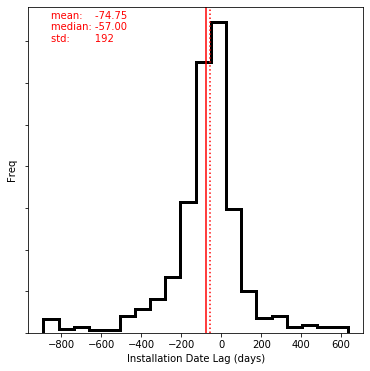

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
dated_slice['dt_del'].dt.days.hist(bins=20, ax=ax, density=True, histtype='step',color='k', lw=3)
ax.set_yticklabels([])
ax.grid(False)
ax.set_ylabel('Freq')
ax.axvline(dated_slice['dt_del'].dt.days.mean(),c='r')
ax.axvline(dated_slice['dt_del'].dt.days.median(),c='r', ls=':')
ax.text(-850,0.0035,f'mean:    {dated_slice["dt_del"].dt.days.mean():.2f}\nmedian: {dated_slice["dt_del"].dt.days.median():.2f}\nstd:        {dated_slice["dt_del"].dt.days.std():.0f}', c='r')
ax.set_xlabel('Installation Date Lag (days)')
plt.savefig(os.path.join(root,'makefigs','install_date_US.png'))
plt.show()

In [ ]:
dated_slice['dt_del']

In [ ]:
dated_slice['diff_days'] = dated_slice['dt_del'].dt.days

In [ ]:
eia_df = eia_df.merge(dated_slice[['dt_obj','diff_days','dt_ns','match_id']], how='left',left_on='plant_match',right_on='match_id')

In [ ]:
eia_df = eia_df.drop(columns=['dt_ns_x']).rename(columns={'dt_ns_y':'date_eia','dt_obj':'date_ours'}).sort_values('diff_days')

In [ ]:
matched_for_inspection = eia_df[~eia_df['match_id'].isna()].merge(gdf[~gdf['match_id'].isna()][['geometry','match_id']], how='left',left_on='match_id', right_on='match_id')

In [ ]:
matched_for_inspection = matched_for_inspection.rename(columns={'geometry_x':'geometry_eiapt','geometry_y':'geometry_ourpolys'})

In [ ]:
matched_for_inspection.to_csv('./US_matched.csv')

In [ ]:
matched_for_inspection

In [ ]:
from shapely import geometry

In [ ]:
geometry.Polygon.representative_point

In [ ]:
matched_for_inspection['geometry_ourpt'] = matched_for_inspection['geometry_ourpolys'].apply(geometry.Polygon.representative_point)

In [ ]:
matched_for_inspection

In [ ]:
matched_for_inspection[['Plant_Name','Utility_Na','geometry_eiapt','date_ours','date_eia','diff_days','geometry_ourpt','match_id']].to_csv(os.path.join(root,'data','US_install_date_summary.csv'))

In [ ]:
matched_for_inspection['our_3395']= gpd.GeoDataFrame(matched_for_inspection, geometry=matched_for_inspection['geometry_ourpt'], crs='epsg:4326').to_crs('epsg:3395').geometry
matched_for_inspection['eia_3395']= gpd.GeoDataFrame(matched_for_inspection, geometry=matched_for_inspection['geometry_eiapt'], crs='epsg:4326').to_crs('epsg:3395').geometry

In [ ]:
matched_for_inspection

In [ ]:
from geopy.distance import distance

In [ ]:
a = geometry.Point(0,50)
b = geometry.Point(1,50)

In [ ]:
(a.x, a.y)

In [ ]:
distance((a.x, a.y),(b.x, b.y))

In [ ]:
dated_slice.loc[dated_slice['dt_del'].dt.days<-750,:]

In [ ]:
eia_df.loc[eia_df['Plant_Code'].isin(dated_slice.loc[dated_slice['dt_del'].dt.days<-750,'match_id'])]

In [ ]:
" we spot check XX installations at the extreme of the distribution."

In [ ]:
gdf.loc[(gdf['iso-3166-1']=='US') ,'capacity_mw'].max()

In [ ]:
gdf.loc[gdf['area']<100,'capacity_mw'].sum()

In [ ]:
(dated_slice.loc[dated_slice['dt_ns']>dt.strptime('2016-06-01','%Y-%m-%d'),'dt_obj'] - dated_slice.loc[dated_slice['dt_ns']>dt.strptime('2016-06-01','%Y-%m-%d'),'dt_ns']).mean()

In [ ]:
eia_df

### Compare WRI, WEPP, IHS

In [ ]:
wri_df = pd.read_csv(os.path.join(root, 'data','WRI_gppd.csv'))

In [ ]:
ihs_df = pd.read_csv(os.path.join(root,'data','ihs_plants_overview.csv'))

In [ ]:

ihs_df = ihs_df[(ihs_df['primary_fuel_types'].isin(solar_types)) & (ihs_df['plant_type']=='Renewable')]

In [ ]:
iso2 = pd.read_csv(os.path.join(root,'data','iso2.csv'))

In [ ]:
iso2['country_lower'] = iso2['country'].str.lower()

In [ ]:
iso_dict = dict(iso2[['country_lower','iso2']].values.tolist())

In [ ]:
ext = {'brunei':'BN',
'democratic republic of congo':'CD',
'fyrom (macedonia)':'MK',
'laos':'LA',
'reunion':'RE',
'russia':'RU',
'south korea':'KR',
'syria':'SY',
'taiwan':'TW',
'u.s. virgin islands':'US',
'uae - abu dhabi':'AE',
'uae - dubai':'AE',
'uae - ras al khaimah':'AE',
'united states':'US',
'vietnam':'VN'}

In [ ]:
iso_dict.update(ext)

In [ ]:
ihs_df['iso2']= ihs_df.country_name.str.lower().map(iso_dict)

In [ ]:
for iso2 in ['CN','JP','US','DE','IT']:
    print(ihs_df.loc[(ihs_df['on_line_year']<2019)&(ihs_df['iso2']==iso2),'total_plant_mwatt'].sum())

In [ ]:
solar_types = [str(cc) for cc in ihs_df['primary_fuel_types'].unique() if 'Solar' in str(cc)]

In [ ]:
wri_df = wri_df.merge(iso2[['iso3','iso2']], how='left',left_on='country', right_on='iso3')

In [ ]:
for iso2_str in ['CN','JP','US','DE','IT']:
    print(iso2_str,wri_df.loc[(wri_df['commissioning_year'].astype(float)<2019)&(wri_df['iso2']==iso2_str)&(wri_df['fuel1']=='Solar'),'capacity_mw'])

In [ ]:
wepp_df = pd.read_csv(os.path.join(root,'data','wepp_allunits.csv'), encoding='Latin-1')

In [ ]:
tally=0
for country in wepp_df.COUNTRY.unique():
    add = wepp_df.loc[(wepp_df.COUNTRY==country)&(wepp_df['FUEL']=='SUN') & ((wepp_df['STATUS']=='OPR') | (wepp_df['YEAR']<=2018)),'MW']
    tally+=add.sum()
    print (tally, country, add.sum(), len(add))

In [ ]:
for country in ['CHINA','JAPAN','USA','GERMANY','ITALY']:
    add = wepp_df.loc[(wepp_df.COUNTRY==country)&(wepp_df['FUEL']=='SUN') & ((wepp_df['STATUS']=='OPR') | (wepp_df['YEAR']<=2018)),'MW']
    print (country, add.sum(), len(add))

In [ ]:
for iso2_str in ['CN','JP','US','DE','IT']:
    print (iso2_str,len(gdf.loc[gdf['iso-3166-1']==iso2_str,'capacity_mw']))

In [ ]:
sorted(wri_df['country_long'].unique())

In [ ]:
wri_df.loc[(wri_df['country']=='CN') & (wri_df['fuel1']=='Solar'),'capacity_mw'].sum()

### get final numbers

In [ ]:
for country_str in gdf[['iso-3166-1','capacity_mw']].groupby('iso-3166-1').sum().sort_values('capacity_mw', ascending=False).index.values:
    N = len(gdf.loc[gdf['iso-3166-1']==country_str,'capacity_mw'])
    gross = int(gdf.loc[gdf['iso-3166-1']==country_str,'capacity_mw'].sum())
    mm = gdf.loc[gdf['iso-3166-1']==country_str,'capacity_mw'].mean()
    
    print (f'{country_str} & {N:,d} & {gross:,d} & {mm:.2f}' )

In [ ]:
gdf['area'].mean()

In [ ]:
len(gdf['iso-3166-1'].unique())

In [ ]:
38913-61

In [ ]:
for cc in ['A','B','C','D']:
    print ((gdf['confidence']==cc).sum()/len(gdf))